In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers as L
from tensorflow.keras import regularizers as R
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from pillow_heif import register_heif_opener
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import tensorflow as tf
import pandas as pd

In [11]:
df = pd.read_csv("aug_final_dataset.csv", index_col=0)
len(df)

350

In [12]:
# ========== STEP 1: Preprocess Spectral Data ==========
spectral_data = df.iloc[:, 2:20].values
scaler = StandardScaler()
spectral_data_scaled = scaler.fit_transform(spectral_data)

In [13]:
register_heif_opener()

IMG_SIZE = (128, 128)
image_data = []
valid_indices = []

for i, row in df.iterrows():
    image_path = os.path.join("RAW", "imgs", row['folder'].strip('/'), row['image_name'])

    try:
        img = load_img(image_path, target_size=IMG_SIZE)
        img_array = img_to_array(img) / 255.0
        image_data.append(img_array)
        valid_indices.append(i)
    except Exception as e:
        print(f"Error loading {image_path}: {e}")


In [14]:
# ========== STEP 3: Filter Data Based on Valid Images ==========
image_data = np.array(image_data)
spectral_data = spectral_data_scaled[valid_indices]
labels = df['class'].values[valid_indices]
labels = LabelEncoder().fit_transform(labels)

In [15]:
# ========== STEP 4: Split ==========
X_img_train, X_img_test, X_spec_train, X_spec_test, y_train, y_test = train_test_split(
    image_data, spectral_data_scaled, labels, test_size=0.2, random_state=42)


In [16]:
# # ========== STEP 5: CNN for Image Branch ==========
# img_input = Input(shape=(*IMG_SIZE, 3))
# x = Conv2D(32, (3, 3), activation='relu')(img_input)
# x = MaxPooling2D()(x)
# x = Conv2D(64, (3, 3), activation='relu')(x)
# x = MaxPooling2D()(x)
# x = Conv2D(128, (3, 3), activation='relu')(x)
# x = MaxPooling2D()(x)
# x = Dropout(0.5)(x)
# x = Flatten()(x)
# x = Dense(128, activation='relu')(x)
# x = Dropout(0.3)(x)
# x = Dense(64, activation='relu')(x)
# x = Dropout(0.3)(x)
# x = Dense(32, activation='relu')(x)
# x = Dropout(0.5)(x)
# x = Dense(18, activation='relu')(x)

In [17]:
weight_decay = 1e-4

# ---------- Image branch (CNN) ----------
img_input = L.Input(shape=(*IMG_SIZE, 3))

# (Optional if you aren't already rescaling elsewhere)
x = L.Rescaling(1./255.0)(img_input)

# (Optional lightweight, helps generalization even with your offline aug)
x = L.RandomFlip("horizontal")(x)
x = L.RandomRotation(0.05)(x)
x = L.RandomZoom(0.05)(x)

def conv_block(x, f, p_drop=0.15):
    x = L.Conv2D(
        f, 3, padding="same", use_bias=False,
        kernel_regularizer=R.l2(weight_decay)
    )(x)
    x = L.BatchNormalization()(x)
    x = L.Activation("relu")(x)
    x = L.SpatialDropout2D(p_drop)(x)
    x = L.MaxPooling2D()(x)
    return x

x = conv_block(x, 32, 0.10)
x = conv_block(x, 64, 0.15)
x = conv_block(x, 128, 0.20)

# Replace Flatten() with GAP to slash params & overfitting
gap = L.GlobalAveragePooling2D()(x)
# (Optionally add max-pooled features too)
gmp = L.GlobalMaxPooling2D()(x)
x = L.Concatenate()([gap, gmp])            # shape: 128+128 = 256

# Compact dense head (regularized)
x = L.Dense(128, activation="relu", kernel_regularizer=R.l2(weight_decay))(x)
x = L.Dropout(0.4)(x)
x = L.Dense(32, activation="relu")(x)
x = L.Dropout(0.3)(x)

# Project to 18 to align with spec branch for Add()
x = L.Dense(18, activation="relu")(x)

In [18]:
# # ========== STEP 6: Dense for Spectrometer Branch ==========
# spec_input = Input(shape=(18,))
# y = Dense(32, activation='relu')(spec_input)
# y = Dropout(0.2)(y)
# y = Dense(18, activation='relu')(y)

In [19]:
spec_input = L.Input(shape=(18,))

y = L.LayerNormalization()(spec_input)     # stable across batch sizes
y = L.Dense(32, activation="relu", kernel_regularizer=R.l2(weight_decay))(y)
y = L.BatchNormalization()(y)
y = L.Dropout(0.15)(y)
y = L.Dense(18, activation="relu")(y)      # matches x's last dim

In [20]:
# # ========== STEP 7: Combine Both ==========
# combined = tf.keras.layers.Add()([x, y]) 

# z = Dense(64, activation='relu')(combined)
# z = Dense(16, activation='relu')(z)
# z = Dropout(0.5)(z)
# z = Dense(1, activation='sigmoid')(z)

In [21]:
# ---------- Fuse & head ----------
combined = L.Add()([x, y])                 # residual-style fusion
combined = L.BatchNormalization()(combined)
z = L.Dense(64, activation="relu", kernel_regularizer=R.l2(weight_decay))(combined)
z = L.Dropout(0.3)(z)
z = L.Dense(16, activation="relu")(z)
z = L.Dropout(0.2)(z)
out = L.Dense(1, activation="sigmoid")(z)

In [22]:
# ========== STEP 8: Final Model ==========
model = Model(inputs=[img_input, spec_input], outputs=out)

optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_flip         │ (None, 128, 128,  │          0 │ rescaling[0][0]   │
│ (RandomFlip)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_rotation     │ (None, 128, 128,  │          0 │ random_flip[0][0] │
│ (RandomRotation)    │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_zoom         │ (None, 128, 128,  │          0 │ random_rotation[… │
│ (RandomZoom)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        864 │ random_zoom[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d   │ (None, 128, 128,  │          0 │ activation[0][0]  │
│ (SpatialDropout2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ spatial_dropout2… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     18,432 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d_1 │ (None, 64, 64,    │          0 │ activation_1[0][… │
│ (SpatialDropout2D)  │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ spatial_dropout2… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     73,728 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_2[0][0]  

 Total params: 135,249 (528.32 KB)

 Trainable params: 134,701 (526.18 KB)

 Non-trainable params: 548 (2.14 KB)

In [23]:
# ========== STEP 9: Train ==========
history=model.fit([X_img_train, X_spec_train], y_train,
          validation_data=([X_img_test, X_spec_test], y_test),
          epochs=100, batch_size=8)

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - accuracy: 0.7000 - loss: 0.6329 - val_accuracy: 0.8286 - val_loss: 0.5653
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - accuracy: 0.7964 - loss: 0.5501 - val_accuracy: 0.8286 - val_loss: 0.4778
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 0.8000 - loss: 0.5623 - val_accuracy: 0.8286 - val_loss: 0.4543
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.8071 - loss: 0.5028 - val_accuracy: 0.8286 - val_loss: 0.4413
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.8000 - loss: 0.5145 - val_accuracy: 0.8286 - val_loss: 0.4114
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.8036 - loss: 0.4737 - val_accuracy: 0.8286 - val_loss: 0.3826
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.8357 - loss: 0.4410 - val_accuracy: 0.8286 - val_loss: 0.3613
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.8107 - loss: 0.4802 - val_acc

In [24]:
y_pred_prob = model.predict([X_img_test, X_spec_test])
y_pred = (y_pred_prob > 0.5).astype("int").flatten()

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step


In [25]:
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=['Unhealthy (u)', 'Healthy (h)']))

Classification Report:

               precision    recall  f1-score   support

Unhealthy (u)       1.00      0.75      0.86        12
  Healthy (h)       0.95      1.00      0.97        58

     accuracy                           0.96        70
    macro avg       0.98      0.88      0.92        70
 weighted avg       0.96      0.96      0.95        70



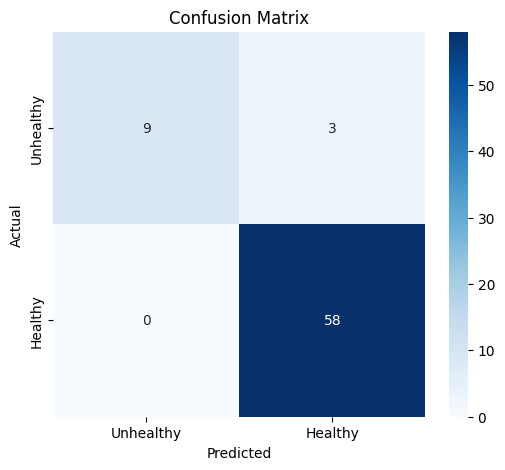

In [26]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Unhealthy', 'Healthy'], yticklabels=['Unhealthy', 'Healthy'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [27]:
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")

Accuracy: 0.9571


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

Classification Report for FusionModel:
               precision    recall  f1-score   support

Unhealthy (u)       1.00      0.75      0.86        12
  Healthy (h)       0.95      1.00      0.97        58

     accuracy                           0.96        70
    macro avg       0.98      0.88      0.92        70
 weighted avg       0.96      0.96      0.95        70

Accuracy: 0.9571


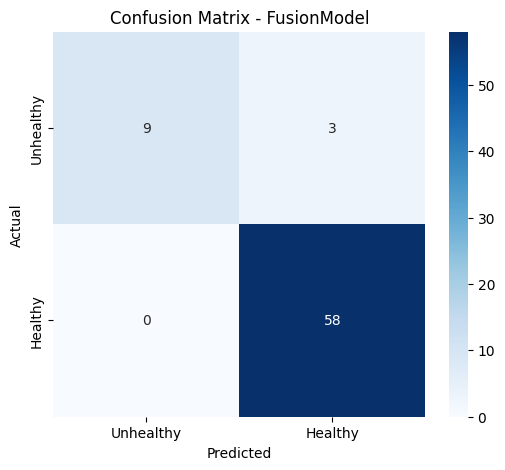

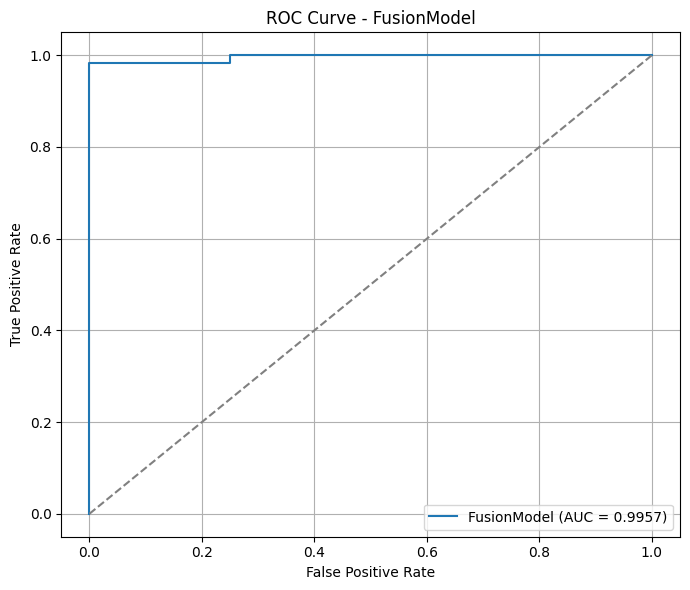

Saved predictions to 'fusionmodel_predictions.csv'


In [28]:
from sklearn.metrics import roc_curve, auc, classification_report, accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

def evaluate_multi_model_with_roc(model, X_img_test, X_spec_test, y_test, model_name="FusionModel"):
    # Predict probabilities and classes
    y_pred_prob = model.predict([X_img_test, X_spec_test])
    y_pred = (y_pred_prob > 0.5).astype("int").flatten()

    # Classification report
    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_test, y_pred, target_names=['Unhealthy (u)', 'Healthy (h)']))

    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}")

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Unhealthy', 'Healthy'], yticklabels=['Unhealthy', 'Healthy'])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    auc_score = auc(fpr, tpr)

    plt.figure(figsize=(7, 6))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.4f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Save to CSV
    df_results = pd.DataFrame({
        'True Label': ['Unhealthy' if x == 0 else 'Healthy' for x in y_test],
        'Predicted Label': ['Unhealthy' if x == 0 else 'Healthy' for x in y_pred],
        'Predicted Probability (Healthy)': y_pred_prob.flatten()
    })
    csv_filename = f"{model_name.lower()}_predictions.csv"
    df_results.to_csv(csv_filename, index=False)
    print(f"Saved predictions to '{csv_filename}'")
evaluate_multi_model_with_roc(model, X_img_test, X_spec_test, y_test, model_name="FusionModel")

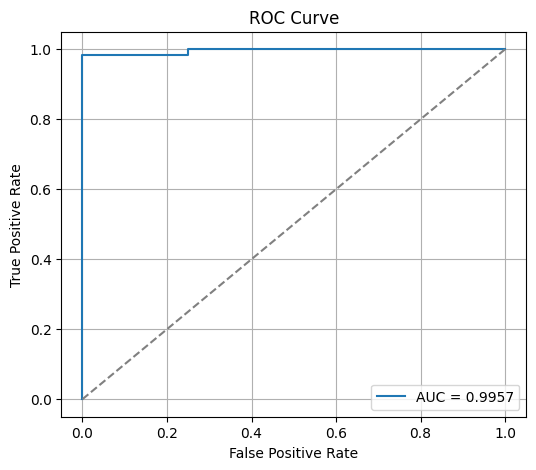

In [29]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

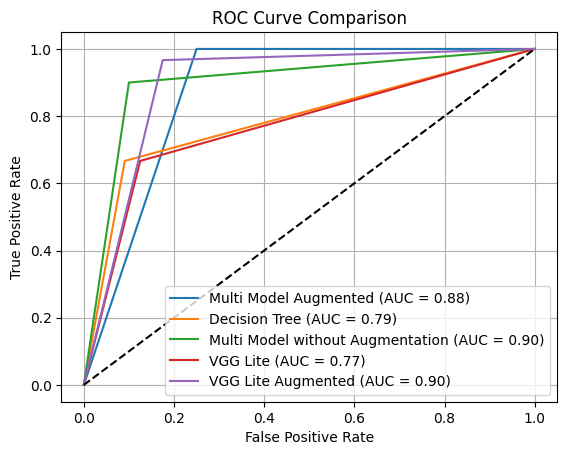

In [38]:
import pandas as pd
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Sample CSV data as strings (replace this with pd.read_csv if using actual files)
csv_multi_model_aug="""True Label,Predicted Label
h,h
h,h
h,h
h,h
h,h
h,h
h,h
h,h
h,h
u,u
u,u
h,h
h,h
h,h
h,h
u,h
u,h
u,u
h,h
u,u
h,h
h,h
h,h
h,h
u,u
h,h
h,h
h,h
h,h
h,h
h,h
h,h
h,h
u,u
u,u
h,h
h,h
h,h
h,h
h,h
h,h
h,h
h,h
h,h
h,h
h,h
h,h
h,h
h,h
h,h
h,h
h,h
h,h
h,h
h,h
h,h
h,h
h,h
h,h
h,h
h,h
h,h
u,h
u,u
u,u
h,h
h,h
h,h
h,h
h,h
"""

csv_decision_tree = """True Label,Predicted Label
u,u
h,u
u,u
h,h
u,u
u,u
u,u
u,u
u,u
u,u
u,u
h,h
h,h
u,h
h,h
u,u
h,u
h,u
h,h
h,h"""

csv_multi_model = """True Label,Predicted Label
h,h
h,h
u,u
h,h
u,u
h,h
h,h
u,h
u,u
h,h
h,u
u,u
u,u
u,u
u,u
h,h
h,h
u,u
h,h
u,u"""

csv_vgglite = """True Label,Predicted Label
h,h
u,u
u,u
h,h
u,u
h,h
h,u
h,h
h,u
u,u
h,u
u,u
u,u
h,h
h,h
h,h
h,u
u,h
h,h
u,u"""

csv_vgglite_aug= """True Label,Predicted Label
u,u
u,u
u,u
u,u
u,u
h,h
u,h
u,u
u,u
h,h
u,h
h,h
h,h
u,u
u,u
h,h
u,h
u,u
u,u
h,h
u,u
u,u
u,u
u,u
u,u
h,h
h,h
h,h
h,h
h,h
h,h
h,h
u,u
u,h
u,u
h,h
u,u
h,u
h,h
h,h
u,h
u,u
u,u
u,u
u,u
h,h
h,h
h,h
u,u
h,h
u,u
h,h
u,u
u,u
u,u
u,u
h,h
h,h
u,u
u,u
u,h
u,h
u,u
h,h
h,h
h,h
h,h
h,h
h,h
u,u"""

# Function to load from CSV string
def load_data(csv_str):
    from io import StringIO
    df = pd.read_csv(StringIO(csv_str))
    df['True Label'] = df['True Label'].map({'u': 0, 'h': 1})
    df['Predicted Label'] = df['Predicted Label'].map({'u': 0, 'h': 1})
    return df

# Load all datasets
mm_aug_df = load_data(csv_multi_model_aug)
dt_df = load_data(csv_decision_tree)
mm_df = load_data(csv_multi_model)
vgg_df = load_data(csv_vgglite)
vgg_aug_df = load_data(csv_vgglite_aug)

# Compute ROC curves and AUC
def compute_roc(df):
    fpr, tpr, _ = roc_curve(df['True Label'], df['Predicted Label'])
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc
fpr_mm_aug, tpr_mm_aug, auc_mm_aug = compute_roc(mm_aug_df)
fpr_dt, tpr_dt, auc_dt = compute_roc(dt_df)
fpr_mm, tpr_mm, auc_mm = compute_roc(mm_df)
fpr_vgg, tpr_vgg, auc_vgg = compute_roc(vgg_df)
fpr_vgg_aug, tpr_vgg_aug, auc_vgg_aug = compute_roc(vgg_aug_df)

# Plotting
plt.figure()
plt.plot(fpr_mm_aug, tpr_mm_aug, label=f'Multi Model Augmented (AUC = {auc_mm_aug:.2f})')
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {auc_dt:.2f})')
plt.plot(fpr_mm, tpr_mm, label=f'Multi Model without Augmentation (AUC = {auc_mm:.2f})')
plt.plot(fpr_vgg, tpr_vgg, label=f'VGG Lite (AUC = {auc_vgg:.2f})')
plt.plot(fpr_vgg_aug, tpr_vgg_aug, label=f'VGG Lite Augmented (AUC = {auc_vgg_aug:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [33]:
from sklearn.metrics import roc_curve, auc, classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from io import StringIO
import numpy as np

def evaluate_multi_model_with_roc(model, X_img_test, X_spec_test, y_test, model_name="FusionModel",
                                  save_full_csv=True, save_min_csv=True, return_csv_string=True):
    # Predict probabilities and classes
    y_pred_prob = model.predict([X_img_test, X_spec_test])
    y_pred_prob = np.asarray(y_pred_prob).ravel()           # ensure shape (N,)
    y_pred = (y_pred_prob > 0.5).astype(int)                # 0/1

    # Classification report
    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_test, y_pred, target_names=['Unhealthy (u)', 'Healthy (h)']))

    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}")

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Unhealthy', 'Healthy'],
                yticklabels=['Unhealthy', 'Healthy'])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)            # assumes 1 = positive ("h")
    auc_score = auc(fpr, tpr)

    plt.figure(figsize=(7, 6))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.4f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ----- CSV outputs -----
    # Full CSV (your original, readable labels + probabilities)
    if save_full_csv:
        df_full = pd.DataFrame({
            'True Label': ['Unhealthy' if x == 0 else 'Healthy' for x in y_test],
            'Predicted Label': ['Unhealthy' if x == 0 else 'Healthy' for x in y_pred],
            'Predicted Probability (Healthy)': y_pred_prob
        })
        full_csv_filename = f"{model_name.lower()}_predictions.csv"
        df_full.to_csv(full_csv_filename, index=False)
        print(f"Saved full predictions to '{full_csv_filename}'")

    # Minimal CSV (exactly the two columns with 'h'/'u')
    csv_multi_model = None
    if save_min_csv or return_csv_string:
        map_hu = {0: 'u', 1: 'h'}
        df_min = pd.DataFrame({
            'True Label': [map_hu[int(x)] for x in y_test],
            'Predicted Label': [map_hu[int(x)] for x in y_pred],
        })

        if save_min_csv:
            min_csv_filename = f"{model_name.lower()}_preds_min.csv"
            df_min.to_csv(min_csv_filename, index=False)
            print(f"Saved minimal predictions to '{min_csv_filename}'")

        if return_csv_string:
            buf = StringIO()
            df_min.to_csv(buf, index=False)
            csv_multi_model = buf.getvalue()
            print("\ncsv_multi_model string preview:")
            print(csv_multi_model.strip())  # shows exactly the CSV text

    return {
        "accuracy": acc,
        "auc": auc_score,
        "csv_multi_model": csv_multi_model
    }

# Example call:
# results = evaluate_multi_model_with_roc(model, X_img_test, X_spec_test, y_test, model_name="FusionModel")
# print(results["csv_multi_model"])  # <- this is the triple-quoted-style CSV string you wanted


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step

Classification Report for FusionModel:
               precision    recall  f1-score   support

Unhealthy (u)       1.00      0.75      0.86        12
  Healthy (h)       0.95      1.00      0.97        58

     accuracy                           0.96        70
    macro avg       0.98      0.88      0.92        70
 weighted avg       0.96      0.96      0.95        70

Accuracy: 0.9571


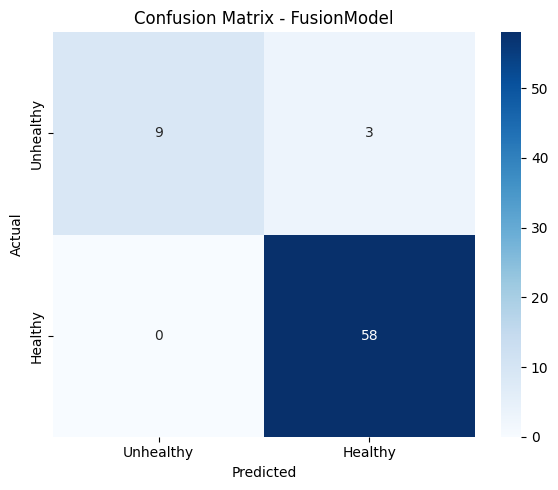

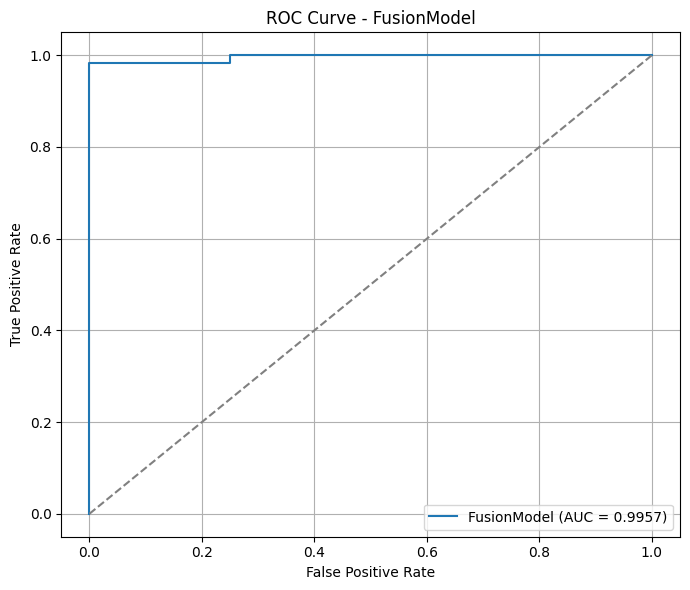

Saved full predictions to 'fusionmodel_predictions.csv'
Saved minimal predictions to 'fusionmodel_preds_min.csv'

csv_multi_model string preview:
True Label,Predicted Label
h,h
h,h
h,h
h,h
h,h
h,h
h,h
h,h
h,h
u,u
u,u
h,h
h,h
h,h
h,h
u,h
u,h
u,u
h,h
u,u
h,h
h,h
h,h
h,h
u,u
h,h
h,h
h,h
h,h
h,h
h,h
h,h
h,h
u,u
u,u
h,h
h,h
h,h
h,h
h,h
h,h
h,h
h,h
h,h
h,h
h,h
h,h
h,h
h,h
h,h
h,h
h,h
h,h
h,h
h,h
h,h
h,h
h,h
h,h
h,h
h,h
h,h
u,h
u,u
u,u
h,h
h,h
h,h
h,h
h,h
True Label,Predicted Label
h,h
h,h
h,h
h,h
h,h
h,h
h,h
h,h
h,h
u,u
u,u
h,h
h,h
h,h
h,h
u,h
u,h
u,u
h,h
u,u
h,h
h,h
h,h
h,h
u,u
h,h
h,h
h,h
h,h
h,h
h,h
h,h
h,h
u,u
u,u
h,h
h,h
h,h
h,h
h,h
h,h
h,h
h,h
h,h
h,h
h,h
h,h
h,h
h,h
h,h
h,h
h,h
h,h
h,h
h,h
h,h
h,h
h,h
h,h
h,h
h,h
h,h
u,h
u,u
u,u
h,h
h,h
h,h
h,h
h,h



In [31]:

# Example call:
results = evaluate_multi_model_with_roc(model, X_img_test, X_spec_test, y_test, model_name="FusionModel")
print(results["csv_multi_model"]) 